In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import PIL.ImageOps
from torch import nn
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) # mean=0.5, std deviation = 0.5
                                #Chage range [0, 1] in image to [-1, 1] => (0-0.5)/0.5 = -1, (1-0.5)/0.5 = 1
                                #(image - mean) / std
                               ])

training_dataset = datasets.MNIST(root = './data', train=True, download = True, transform=transform)
validation_dataset = datasets.MNIST(root = './data', train=False, download = True, transform=transform)

training_batch_size = 32
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=training_batch_size, shuffle=True)

validation_batch_size = 100
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=validation_batch_size, shuffle=True)

In [3]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy().transpose(1, 2, 0) #(1, 28, 28) to (28, 28, 1)
    #Change range from [-1, 1] back to [0, 1]. image * std + mean
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    image = image.clip(0, 1)
    return image

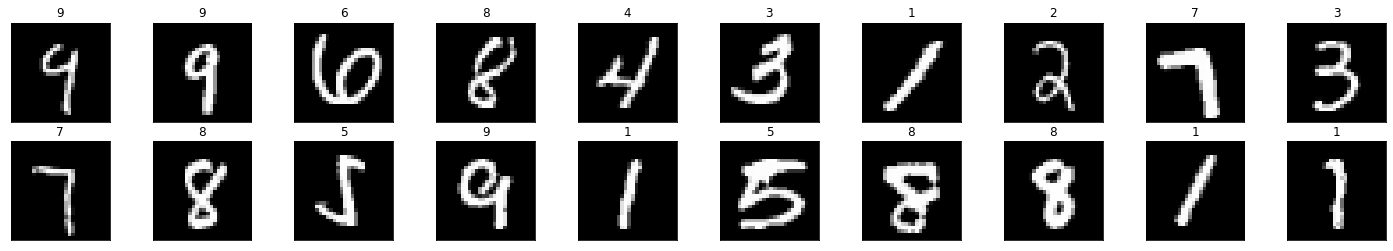

In [4]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [5]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) #Raw output, doesn't need activation function
        return x

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(500, 10)
                
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
print("Device:", device)
#model = Classifier(784, 125, 65, 10).to(device)
model = LeNet().to(device)
#summary(model, (1, 1, 28*28))
summary(model, (1, 28, 28))

Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
           Dropout-4                  [-1, 500]               0
            Linear-5                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.77
----------------------------------------------------------------


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [9]:
epochs = 12
running_lost_history = []
running_corrects_history = []

val_running_lost_history = []
val_running_corrects_history = []
tbar = tqdm(range(epochs), desc = "Total Progress")
for epoch in tbar:
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    tqdm.write("Starting epoch {}/{}...".format(epoch+1, epochs))
    progress = tqdm(total=len(training_loader.dataset))
    for inputs, labels in training_loader:
        #inputs = inputs.view(inputs.shape[0], -1) #(100, 784)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) # Output of torch.max = (max, max_indices)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        progress.update(inputs.shape[0])
    
    else:
        with torch.no_grad(): # Temporarily set all required grad flags to False
            for val_inputs, val_labels in validation_loader:
                #val_inputs = val_inputs.view(val_inputs.shape[0], -1) #(100, 784)
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1) # Output of torch.max = (max, max_indices)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                           
        epoch_loss = running_loss / len(training_loader) / training_batch_size
        epoch_acc = running_corrects.float() / len(training_loader) / training_batch_size * 100 #Accuracy rate
        running_lost_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        tqdm.write ("Training Loss: {:.4f}, acc: {:.2f}%".format(epoch_loss, epoch_acc.item()))
        
        val_epoch_loss = val_running_loss / len(validation_loader) / validation_batch_size
        val_epoch_acc = val_running_corrects.float() / len(validation_loader) / validation_batch_size * 100 #Accuracy rate
        val_running_lost_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        tqdm.write ("Validation Loss: {:.4f}, validation acc: {:.2f}%".format(val_epoch_loss, val_epoch_acc.item()))
    progress.close()

Starting epoch 1/12...


Training Loss: 0.0046, acc: 95.42%
Validation Loss: 0.0005, validation acc: 98.37%

Starting epoch 2/12...


Training Loss: 0.0017, acc: 98.40%
Validation Loss: 0.0004, validation acc: 98.63%

Starting epoch 3/12...


Training Loss: 0.0012, acc: 98.81%
Validation Loss: 0.0004, validation acc: 98.75%

Starting epoch 4/12...


Training Loss: 0.0010, acc: 99.02%
Validation Loss: 0.0004, validation acc: 98.91%

Starting epoch 5/12...


Training Loss: 0.0009, acc: 99.17%
Validation Loss: 0.0004, validation acc: 98.87%

Starting epoch 6/12...


Training Loss: 0.0007, acc: 99.29%
Validation Loss: 0.0005, validation acc: 98.85%

Starting epoch 7/12...


Training Loss: 0.0007, acc: 99.27%
Validation Loss: 0.0003, validation acc: 99.09%

Starting epoch 8/12...


Training Loss: 0.0006, acc: 99.40%
Validation Loss: 0.0004, validation acc: 98.99%

Starting epoch 9/12...


Training Loss: 0.0005, acc: 99.50%
Validation Loss: 0.0004, validation acc: 99.10%

Starting epoch 10/12...


Training Loss: 0.0005, acc: 99.54%
Validation Loss: 0.0005, validation acc: 99.02%

Starting epoch 11/12...


Training Loss: 0.0005, acc: 99.55%
Validation Loss: 0.0003, validation acc: 99.08%

Starting epoch 12/12...


Training Loss: 0.0004, acc: 99.59%
Validation Loss: 0.0004, validation acc: 99.00%




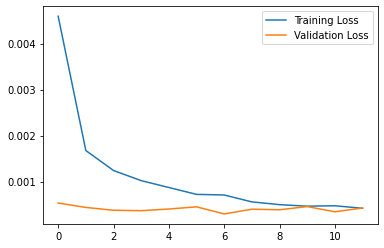

In [10]:
plt.plot(running_lost_history, label="Training Loss")
plt.plot(val_running_lost_history, label="Validation Loss")
plt.legend()

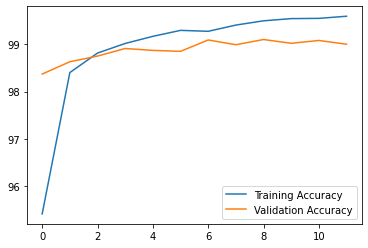

In [11]:
plt.plot(running_corrects_history, label = "Training Accuracy")
plt.plot(val_running_corrects_history, label = "Validation Accuracy")
plt.legend()

<Response [200]>


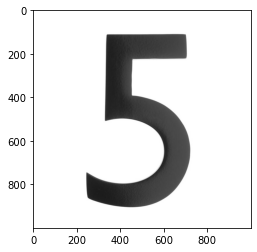

In [12]:
import requests
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
plt.imshow(img)

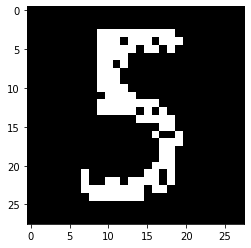

In [13]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [14]:
val_input = img
#val_input = val_input.view(img.shape[0], -1) #(1, 784)
val_input = val_input.view(1, 1, 28, 28).to(device)
val_output = model(val_input)
_, val_pred = torch.max(val_output, 1)
print(val_pred.item())

5


Accuracy Rate = 99.0%


<Figure size 1800x288 with 0 Axes>

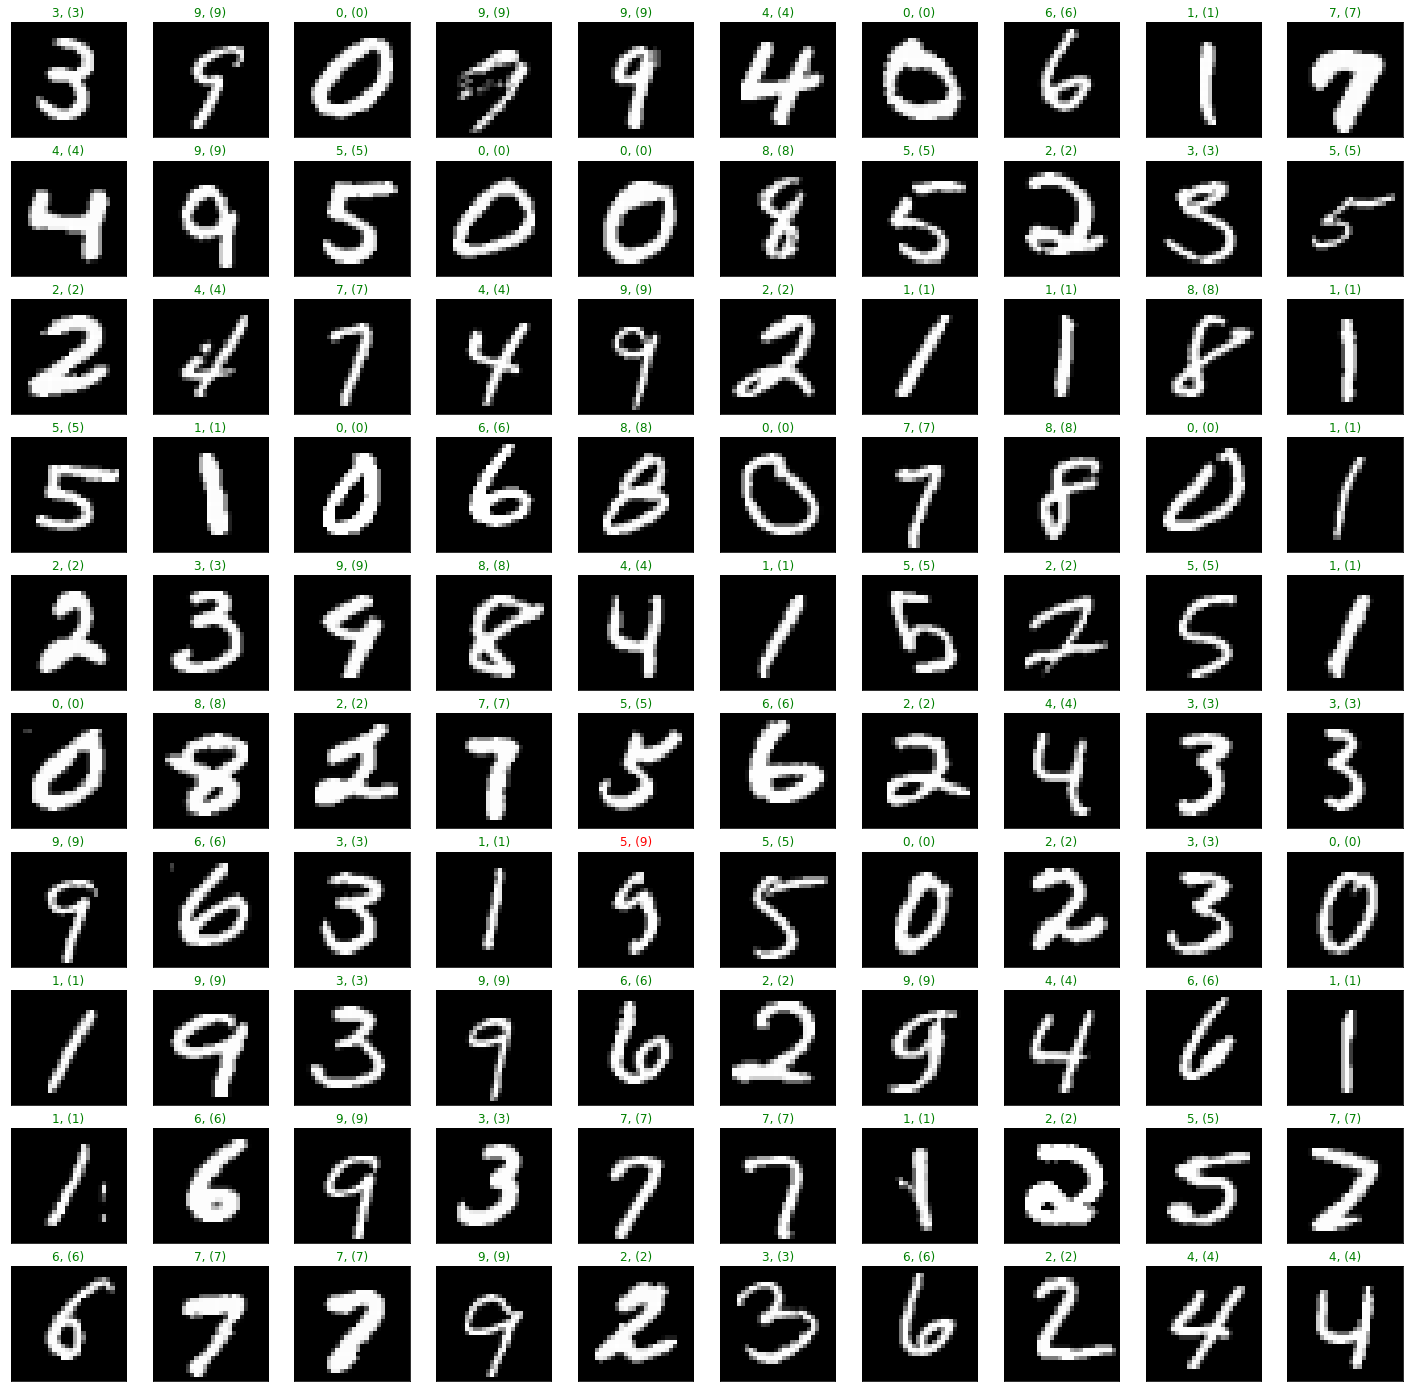

In [15]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = model(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(100):    
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{}, ({})".format(str(val_preds[idx].item()), str(labels[idx].item())), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))